[Reference](https://medium.com/gousto-engineering-techbrunch/the-problem-with-gradient-boosting-gradient-boosted-gremlins-a69908dcea94)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

taxis = sns.load_dataset('taxis')

In [2]:
train_features = ['passengers', 'fare', 'tip', 'tolls']
target_feature = 'distance'
X_train = taxis[train_features].to_numpy()
y_train = taxis[target_feature].to_numpy()

Text(0.5, 1.0, 'distance, range 0.0 to 36.7')

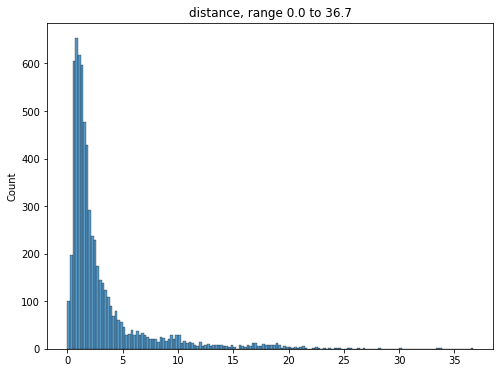

In [3]:
gs_kw = dict(width_ratios=[1], height_ratios=[1])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), gridspec_kw=gs_kw)
    
axs = sns.histplot(y_train, ax = ax)
axs.set_title(f'{target_feature}, range {y_train.min()} to {y_train.max()}')

In [4]:
from sklearn.ensemble import RandomForestRegressor

# create our model with some arb. parameters
regr = RandomForestRegressor(max_depth=None, 
                             criterion = 'squared_error',
                             n_estimators = 200,
                             min_samples_leaf=1,
                             random_state=0)

# fit our model to our training data
# who even cares about cross-validation anymore?
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [5]:
import lightgbm as lgb

# define our model parameters, keeping similar to our RF parameters
boosting_rounds = 200

hp = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'l2',
    'force_col_wise':True,
    'max_depth':-1,
    'min_data_in_leaf':1,
    'feature_pre_filter':False
}

# create Dataset class with our training features X and target y
train_data = lgb.Dataset(
    X_train,
    y_train,
    feature_name = train_features
)

# train the model and validate against our training set
# overfitting doesn't exist, we're fineeee
lgbmodel = lgb.train(
    hp,
    train_data,
    boosting_rounds,
    valid_sets = [train_data],
    # callbacks = [lgb.log_evaluation(period=10)]
)

[1]	training's l2: 12.0683
[2]	training's l2: 9.97537
[3]	training's l2: 8.27963
[4]	training's l2: 6.90218
[5]	training's l2: 5.78423
[6]	training's l2: 4.87846
[7]	training's l2: 4.13802
[8]	training's l2: 3.53506
[9]	training's l2: 3.04282
[10]	training's l2: 2.64585
[11]	training's l2: 2.31805
[12]	training's l2: 2.05127
[13]	training's l2: 1.83339
[14]	training's l2: 1.65348
[15]	training's l2: 1.50864
[16]	training's l2: 1.39147
[17]	training's l2: 1.28949
[18]	training's l2: 1.20546
[19]	training's l2: 1.13659
[20]	training's l2: 1.07832
[21]	training's l2: 1.03356
[22]	training's l2: 0.987397
[23]	training's l2: 0.955297
[24]	training's l2: 0.926221
[25]	training's l2: 0.897838
[26]	training's l2: 0.876788
[27]	training's l2: 0.859059
[28]	training's l2: 0.843084
[29]	training's l2: 0.831849
[30]	training's l2: 0.816195
[31]	training's l2: 0.807344
[32]	training's l2: 0.798741
[33]	training's l2: 0.790199
[34]	training's l2: 0.778119
[35]	training's l2: 0.773481
[36]	training's

In [6]:
# how many predictions
n_predict = 1000
X_predict = np.empty([n_predict, 4], float)

# populate X_predict for all values of X that we have
i = 0
for feature in train_features:
    train_min = X_train.T[i].min() 
    train_max = X_train.T[i].max()
    train_mean = X_train.T[i].mean()
    # just to ensure we're predicting on X values outside our training range
    test_min = train_min - train_mean
    test_max = train_max + train_mean

    arr = np.linspace(test_min, test_max, n_predict)
    # shuffle so combinations across features are random
    np.random.shuffle(arr)
    
    X_predict.T[i] = arr
    i += 1
    
# predictions!
y_predict_rf = regr.predict(X_predict)
y_predict_gb = lgbmodel.predict(X_predict)

Text(0.5, 1.0, 'distance, range 0.0 to 36.7')

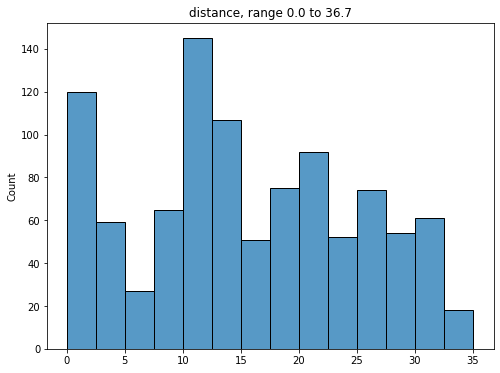

In [7]:
gs_kw = dict(width_ratios=[1], height_ratios=[1])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), gridspec_kw=gs_kw)
    
axs = sns.histplot(y_predict_rf, ax = ax)
axs.set_title(f'{target_feature}, range {y_train.min()} to {y_train.max()}')

Text(0.5, 1.0, 'distance, range 0.0 to 36.7')

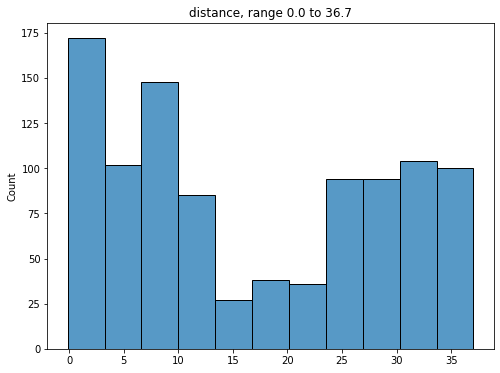

In [8]:
gs_kw = dict(width_ratios=[1], height_ratios=[1])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), gridspec_kw=gs_kw)
    
axs = sns.histplot(y_predict_gb, ax = ax)
axs.set_title(f'{target_feature}, range {y_train.min()} to {y_train.max()}')

The aim of training is to minimise MSE when growing the tree, we can evaluate MSE at each node that we split
![pic1](https://miro.medium.com/max/666/0*zKyY3jxsTgwLHqIE)
![pic2](https://miro.medium.com/max/1400/1*nT33PwDnzLtGqnE-SuIn4Q.png)

# Random Forests


![pic3](https://miro.medium.com/max/680/0*BoINES-rAnDSXH_U)

# Gradient Boosted Trees


The main difference between RF and GB models is that where RF takes the average of many models, GB trees are additive, meaning we sum the predictions between all trees.<br>
![pic4](https://miro.medium.com/max/684/0*KeF_li3khxMzXdNG) <br>
![pic5](https://miro.medium.com/max/650/0*T9Q26xoqTdTjnFZp)

In [9]:
import lightgbm as lgb

# my training dataset
X_train = np.array([[0.4, 0.0, 0.6], [0.0, 0.0, 0.4]]).T
y_train = np.array([1, 0, 0.5])
train_features = [f'feature_{i}' for i in range(2)]

# define our model parameters
boosting_rounds = 2
hp = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'l2',
    'force_col_wise':True,
    'max_depth':1,
    'min_data_in_leaf':1,
    'feature_pre_filter':False,
    'learning_rate': 1
}

# create Dataset class with our training features X and target y
train_data = lgb.Dataset(
    X_train,
    y_train,
    feature_name = train_features
)

# train the model and validate against our training set
lgbmodel = lgb.train(
    hp,
    train_data,
    boosting_rounds,
    valid_sets = [train_data],
    # callbacks = [lgb.log_evaluation(period=10)]
)

[1]	training's l2: 0.0416667
[2]	training's l2: 0.0104167


In [10]:
manual_lgbm = pd.DataFrame(X_train, columns = train_features)
manual_lgbm['y'] = y_train

#first step
manual_lgbm['f_0'] = 0
manual_lgbm['r_0'] = manual_lgbm['y'] - manual_lgbm['f_0']

# tree 1
manual_lgbm.loc[manual_lgbm['feature_0'] <= 0, 'f_1'] = 0.000
manual_lgbm.loc[manual_lgbm['feature_0'] > 0, 'f_1'] = 0.750
# residuals of tree 1
manual_lgbm['r_1'] = manual_lgbm['r_0'] - manual_lgbm['f_1']

# tree 2
manual_lgbm.loc[manual_lgbm['feature_1'] <= 0, 'f_2'] = 0.125
manual_lgbm.loc[manual_lgbm['feature_1'] > 0, 'f_2'] = -0.250
# residuals of tree 2
manual_lgbm['r_2'] = manual_lgbm['r_1'] - manual_lgbm['f_2']

# predictions
manual_lgbm['y_pred'] = manual_lgbm['f_0'] + manual_lgbm['f_1'] + manual_lgbm['f_2']